### XGBoost vs GBM

#### Regularization:
Standard GBM implementation has no regularization like XGBoost, therefore it also helps to reduce overfitting.
In fact, XGBoost is also known as ‘regularized boosting‘ technique.
#### Parallel Processing:
XGBoost implements parallel processing and is blazingly faster as compared to GBM.
But hang on, we know that boosting is sequential process so how can it be parallelized? We know that each tree can be built only after the previous one, so what stops us from making a tree using all cores? I hope you get where I’m coming from. Check this link out to explore further.
XGBoost also supports implementation on Hadoop.
#### High Flexibility
XGBoost allow users to define custom optimization objectives and evaluation criteria.
This adds a whole new dimension to the model and there is no limit to what we can do.
#### Handling Missing Values
XGBoost has an in-built routine to handle missing values.
User is required to supply a different value than other observations and pass that as a parameter. XGBoost tries different things as it encounters a missing value on each node and learns which path to take for missing values in future.
#### Tree Pruning:
A GBM would stop splitting a node when it encounters a negative loss in the split. Thus it is more of a greedy algorithm.
XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.
Another advantage is that sometimes a split of negative loss say -2 may be followed by a split of positive loss +10. GBM would stop as it encounters -2. But XGBoost will go deeper and it will see a combined effect of +8 of the split and keep both.
#### Built-in Cross-Validation
XGBoost allows user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.
This is unlike GBM where we have to run a grid-search and only a limited values can be tested.
#### Continue on Existing Model
User can start training an XGBoost model from its last iteration of previous run. This can be of significant advantage in certain specific applications.
GBM implementation of sklearn also has this feature so they are even on this point.


### XGBoost parameters

#### General Parameters
These define the overall functionality of XGBoost.
##### booster [default=gbtree]
Select the type of model to run at each iteration. It has 2 options:
gbtree: tree-based models
gblinear: linear models
##### silent [default=0]:
Silent mode is activated is set to 1, i.e. no running messages will be printed.
It’s generally good to keep it 0 as the messages might help in understanding the model.
##### nthread [default to maximum number of threads available if not set]
This is used for parallel processing and number of cores in the system should be entered
If you wish to run on all cores, value should not be entered and algorithm will detect automatically

#### Boosting parameteres
##### eta [default=0.3]
Analogous to learning rate in GBM
Makes the model more robust by shrinking the weights on each step
Typical final values to be used: 0.01-0.2
##### min_child_weight [default=1]
Defines the minimum sum of weights of all observations required in a child.
This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
Too high values can lead to under-fitting hence, it should be tuned using CV.
##### max_depth [default=6]
The maximum depth of a tree, same as GBM.
Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
Should be tuned using CV.
Typical values: 3-10
##### max_leaf_nodes
The maximum number of terminal nodes or leaves in a tree.
Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
If this is defined, XGB will ignore max_depth.
##### gamma [default=0]
A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
##### max_delta_step [default=0]
In maximum delta step we allow each tree’s weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative.
Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced.
This is generally not used but you can explore further if you wish.
##### subsample [default=1]
Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
Typical values: 0.5-1
##### colsample_bytree [default=1]
Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.
Typical values: 0.5-1
##### colsample_bylevel [default=1]
Denotes the subsample ratio of columns for each split, in each level.
##### lambda [default=1]
L2 regularization term on weights (analogous to Ridge regression)
This used to handle the regularization part of XGBoost. 
##### alpha [default=0]
L1 regularization term on weight (analogous to Lasso regression)
Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
scale_pos_weight [default=1]
A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.

#### Learning Task Parameters
These parameters are used to define the optimization objective the metric to be calculated at each step.
##### objective [default=reg:linear]
This defines the loss function to be minimized. Mostly used values are:
binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
you also need to set an additional num_class (number of classes) parameter defining the number of unique classes
multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.
##### eval_metric [ default according to objective ]
The metric to be used for validation data.
The default values are rmse for regression and error for classification.
Typical values are:
rmse – root mean square error
mae – mean absolute error
logloss – negative log-likelihood
error – Binary classification error rate (0.5 threshold)
merror – Multiclass classification error rate
mlogloss – Multiclass logloss
##### auc: Area under the curve
seed [default=0]
The random number seed.
Can be used for generating reproducible results and also for parameter tuning.

In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('train_modified.csv')

/home/pankaj/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/pankaj/.local/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 51 columns):
Disbursed                        87020 non-null float64
Existing_EMI                     87020 non-null float64
ID                               87020 non-null object
Loan_Amount_Applied              87020 non-null float64
Loan_Tenure_Applied              87020 non-null float64
Monthly_Income                   87020 non-null int64
Var4                             87020 non-null int64
Var5                             87020 non-null int64
Age                              87020 non-null int64
EMI_Loan_Submitted_Missing       87020 non-null int64
Interest_Rate_Missing            87020 non-null int64
Loan_Amount_Submitted_Missing    87020 non-null int64
Loan_Tenure_Submitted_Missing    87020 non-null int64
Processing_Fee_Missing           87020 non-null int64
Device_Type_0                    87020 non-null int64
Device_Type_1                    87020 non-null int64
Filled_Form_0     

In [3]:
train.head()

,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,0.0,0.0,ID000002C20,300000.0,5.0,20000,1,0,37,1,...,0,0,0,0,1,1,0,1,0,0
1,0.0,0.0,ID000004E40,200000.0,2.0,35000,3,13,30,0,...,0,0,0,0,1,0,1,1,0,0
2,0.0,0.0,ID000007H20,600000.0,4.0,22500,1,0,34,1,...,0,0,0,0,0,0,1,0,0,1
3,0.0,0.0,ID000008I30,1000000.0,5.0,35000,3,10,28,1,...,0,0,0,0,0,0,1,0,0,1
4,0.0,25000.0,ID000009J40,500000.0,2.0,100000,3,17,31,1,...,0,0,0,0,0,0,1,0,0,1


In [4]:
X_train=train
## drop ID column and target column
X_train = X_train.drop('ID',axis=1)
X_train = X_train.drop('Disbursed',axis=1)
Y_train = train['Disbursed']

In [5]:
from sklearn.cross_validation import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

In [33]:
def modelfit(alg, train_x, train_y,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train_x, label=train_y)
        ##using internal Cross Validation function
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        print("Best n_estimator: ", cvresult.shape[0])
        ##setting the best parameter as the final parameter
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm with best parameter on the data
    alg.fit(train_x, train_y, eval_metric='auc',verbose=True)
        
    #Predict training set:
    dtrain_predictions = alg.predict(train_x)
    dtrain_predprob = alg.predict_proba(train_x)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(train_y, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(train_y, dtrain_predprob))
    
    ##plot feature importance                
    xgb.plot_importance(alg, ax=None, height=0.2, xlim=None, ylim=None, 
    title='Feature importance', xlabel='F score', ylabel='Features', importance_type='weight', 
    max_num_features=None, grid=True)

Best n_estimator:  108

Model Report
Accuracy : 0.9856
AUC Score (Train): 0.905626


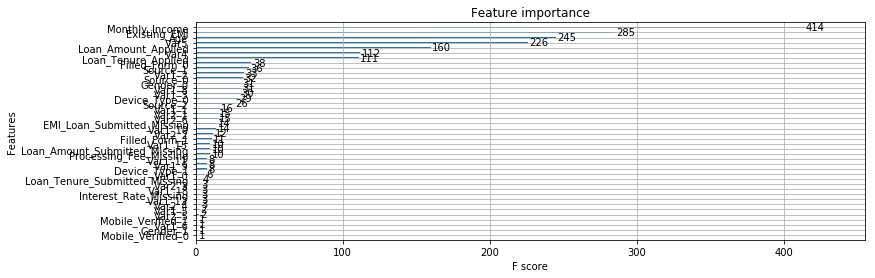

In [34]:
## lets train
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train_x, train_y)

#### Tune max_depth and min_child_weight

In [38]:
param_test1 = {
 'max_depth':[3,5,7,9],
 'min_child_weight':[1,3,5]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=108, max_depth=5,
           min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
           objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
           param_grid = param_test1, scoring='roc_auc',n_jobs=10,iid=False, cv=5, verbose=2)

gsearch1.fit(train_x,train_y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] min_child_weight=1, max_depth=3 .................................
[CV] min_child_weight=1, max_depth=3 .................................
[CV] min_child_weight=1, max_depth=3 .................................
[CV] min_child_weight=1, max_depth=3 .................................
[CV] min_child_weight=1, max_depth=3 .................................
[CV] min_child_weight=3, max_depth=3 .................................
[CV] min_child_weight=3, max_depth=3 .................................
[CV] min_child_weight=3, max_depth=3 .................................
[CV] min_child_weight=3, max_depth=3 .................................
[CV] min_child_weight=3, max_depth=3 .................................
[CV] min_child_weight=5, max_depth=3 .................................
[CV] min_child_weight=5, max_depth=3 .................................
[CV] min_child_weight=5, max_depth=3 .................................
[CV] min_child_w

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  3.0min


[CV] ........................ min_child_weight=1, max_depth=7 - 1.4min
[CV] min_child_weight=5, max_depth=7 .................................
[CV] ........................ min_child_weight=1, max_depth=7 - 1.4min
[CV] min_child_weight=5, max_depth=7 .................................
[CV] ........................ min_child_weight=3, max_depth=7 - 1.3min
[CV] ........................ min_child_weight=1, max_depth=7 - 1.4min
[CV] min_child_weight=5, max_depth=7 .................................
[CV] min_child_weight=5, max_depth=7 .................................
[CV] ........................ min_child_weight=1, max_depth=7 - 1.4min
[CV] min_child_weight=5, max_depth=7 .................................
[CV] ........................ min_child_weight=3, max_depth=7 - 1.3min
[CV] min_child_weight=1, max_depth=9 .................................
[CV] ........................ min_child_weight=3, max_depth=7 - 1.4min
[CV] min_child_weight=1, max_depth=9 .................................
[CV] .

Process ForkPoolWorker-29:
Process ForkPoolWorker-26:
Process ForkPoolWorker-27:
Process ForkPoolWorker-34:
Process ForkPoolWorker-30:
Process ForkPoolWorker-25:
Process ForkPoolWorker-33:
Process ForkPoolWorker-31:
Process ForkPoolWorker-32:
Process ForkPoolWorker-28:


KeyboardInterrupt: 

In [39]:
print(gsearch1.grid_scores_) 
print(gsearch1.best_params_)
print(gsearch1.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

This takes quite a time to train on a descent system, hence i ve not included all the stps :
like wise the tuning can be done with different values of :
* gamma: range from 0.1 to 0.5 with a step of 0.1
* subsample: range from 0.6 to 1.0 with a step of 0.1
* colsample_bytree: range from 0.6 to 1.0 with a step of 0.1
* reg_alpha : [1e-5, 1e-2, 0.1, 1, 100]
* Reducing learning rate